In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVR

%matplotlib inline

In [2]:
df = pd.read_csv('AMZN_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [3]:
df.index = pd.to_datetime(df.index)

In [4]:
df2 = df.drop(['sma252','sma50','ema22zone','ema252zone', 'ema50', 'BBU_5_2.0', 'ema7zone', 'sma22', 'ema50zone', 'BBL_5_2.0', 'BBM_5_2.0', 'ema22', 'sma7','ema252'],axis = 1)

In [5]:
corrs = df2.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
correlations = temp[temp.index % 2 == 0]

In [6]:
correlations

,1,2,R2


In [7]:
df2 = df2[df2.index > '2010-1-1']

In [8]:
X = df2.shift(1).dropna()
y = df2['adjustedclose'].iloc[1:]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, test_size = .2)

In [10]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [11]:
X_train_scaled

,low,open,volume,high,close,adjustedclose,rsi,BBB_5_2.0,BBP_5_2.0,ema7,day_direction,golden_crossover_short,death_crossover_short,golden_crossover_long,death_crossover_long,RSI_overbought_cross,RSI_oversold_cross,RSI_overbought,RSI_oversold,momentum
0,-0.513044,-0.470734,6.569028,-0.474891,-0.518822,-0.518822,2.344303,2.147055,1.588133,-0.554139,0.945446,-0.117851,-0.126598,-0.035311,-0.028826,-0.158450,-0.076456,2.971978,-0.093776,0.941558
1,-0.787674,-0.786468,-0.841874,-0.788599,-0.788975,-0.788975,-0.543093,-0.425710,-0.835754,-0.785501,-1.057702,-0.117851,-0.126598,-0.035311,-0.028826,-0.158450,-0.076456,-0.336476,-0.093776,-0.230154
2,-0.733516,-0.730695,-0.165466,-0.730978,-0.733349,-0.733349,-1.270621,0.047518,0.773162,-0.731333,0.945446,-0.117851,-0.126598,-0.035311,-0.028826,-0.158450,-0.076456,-0.336476,-0.093776,-0.339154
3,-0.153082,-0.157429,-0.757403,-0.165341,-0.161186,-0.161186,0.388189,-1.233448,-1.281094,-0.158289,-1.057702,-0.117851,-0.126598,-0.035311,-0.028826,-0.158450,-0.076456,-0.336476,-0.093776,-0.125515
4,2.102230,2.077879,-0.821611,2.054960,2.074768,2.074768,-0.857408,-0.940601,-0.542727,2.093875,0.945446,-0.117851,-0.126598,-0.035311,-0.028826,-0.158450,-0.076456,-0.336476,-0.093776,-0.645099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,-0.314870,-0.315533,-0.559928,-0.322569,-0.318111,-0.318111,0.637856,-0.319474,0.716583,-0.326115,-1.057702,-0.117851,-0.126598,-0.035311,-0.028826,-0.158450,-0.076456,-0.336476,-0.093776,0.194882
2405,-0.743460,-0.746299,-0.265275,-0.740511,-0.738339,-0.738339,-1.020803,0.292592,1.286560,-0.741274,0.945446,-0.117851,-0.126598,-0.035311,-0.028826,-0.158450,-0.076456,-0.336476,-0.093776,-0.050399
2406,-0.713148,-0.715750,-0.474291,-0.711902,-0.709727,-0.709727,0.381583,-0.543666,1.493638,-0.713620,0.945446,-0.117851,-0.126598,-0.035311,-0.028826,-0.158450,-0.076456,-0.336476,-0.093776,-0.044295
2407,-0.662752,-0.665988,-0.473953,-0.659540,-0.658394,-0.658394,1.489008,-0.729321,1.165245,-0.662649,0.945446,-0.117851,-0.126598,-0.035311,-0.028826,6.311142,-0.076456,2.971978,-0.093776,0.025465


In [12]:
svr = LinearSVR(random_state = 42, max_iter = 10e5)

In [13]:
svrmodel = svr.fit(X_train_scaled, y_train)

In [53]:
train_score = svr.score(X_train_scaled, y_train)
y_hat_train = svr.predict(X_train_scaled)
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
train_cv_score = cross_val_score(svrmodel, X_train_scaled, y_train, n_jobs = -1).mean()

print(f'Train Score : {train_score}')
print(f'Train RMSE : {train_rmse}')
print(f'Mean Train Cross-Validation Score: {train_cv_score}')

Train Score : 0.9990214197082179
Train RMSE : 32.280505992629045
Mean Train Cross-Validation Score: 0.9979365918889324


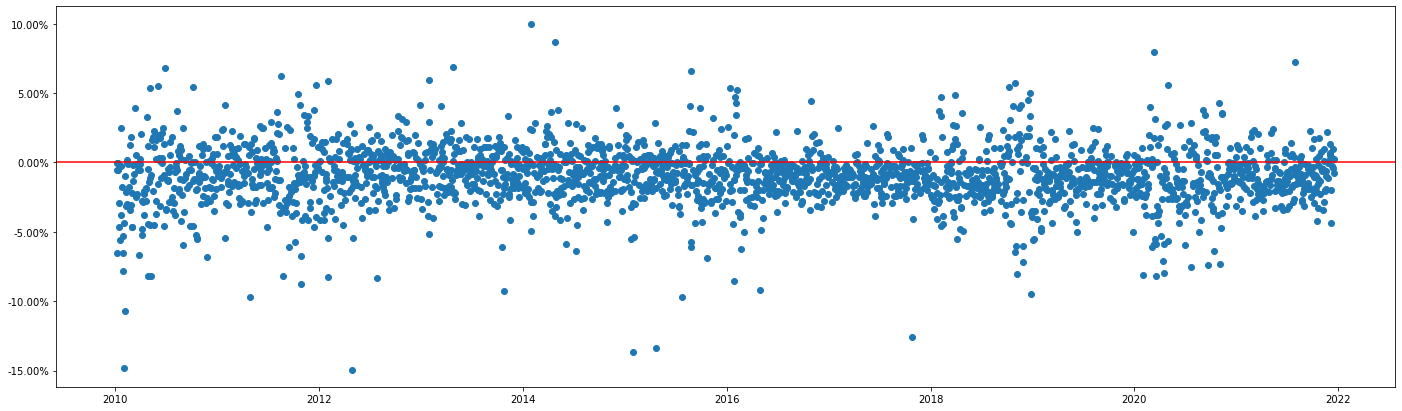

In [61]:
fig, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_train.index, (y_hat_train - y_train)/y_train)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = 1, color = 'red');

In [55]:
test_score = svr.score(X_test_scaled, y_test)
y_hat_test = svr.predict(X_test_scaled)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(f'Test Score : {test_score}')
print(f'Test RMSE : {test_rmse}')

Test Score : 0.9988457580162919
Test RMSE : 35.77320031201362


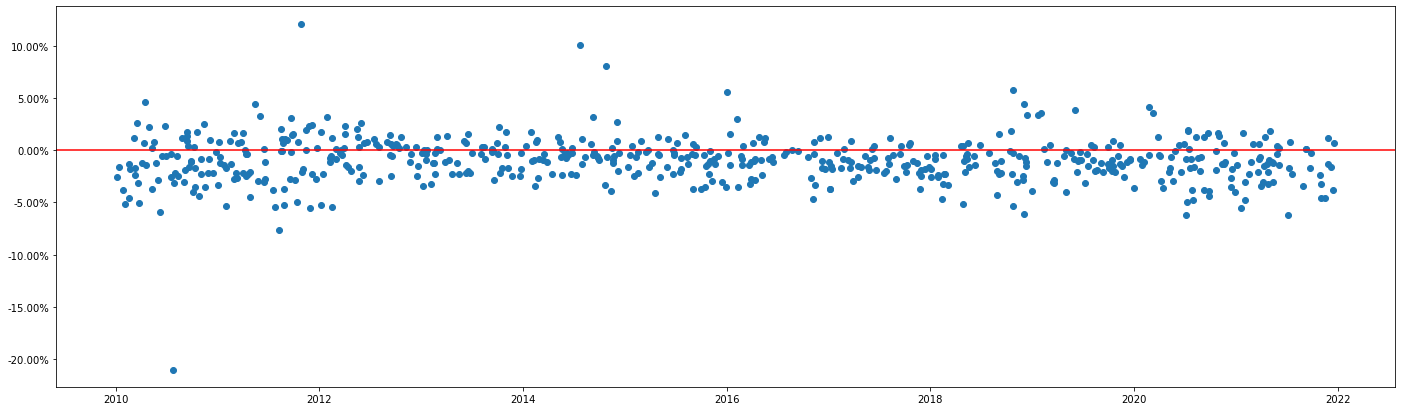

In [62]:
fig, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_test.index, (y_hat_test - y_test)/y_test)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = 1, color = 'red');